In [1]:
import csv
import os
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator

In [2]:
def sort_df_by_custom_order(df, column, custom_order):
    df[column] = pd.Categorical(df[column], categories=custom_order, ordered=True)
    df = df.sort_values(by=column)
    return df

def get_experiment_dataframe(experiment_csv_folder_path):
    path = experiment_csv_folder_path
    # or unix / linux / mac path

    # Get the files from the path provided in the OP
    files = Path(path).glob('*.csv')  # .rglob to get subdirectories

    # for f in files:
    #     print(f.stem)


    dfs = list()
    for f in files:
        data = pd.read_csv(f, index_col="id", header=0)
        # .stem is method for pathlib objects to get the filename w/o the extension
        data['file'] = f.stem
        dfs.append(data)

    exp_df = pd.concat(dfs, ignore_index=False)
    return exp_df

def output_latex_table_content(experiment_dataframe, output_file_name, configs):

    #standard deviation is rounded to 3 decimal places
    means = experiment_dataframe.groupby(['weight initialization policy'])[
        'best_accuracy'].mean().round(3)
    stds = experiment_dataframe.groupby(['weight initialization policy'])[
        'best_accuracy'].std().round(3)

    table_values = means.astype(str) + "$\pm$" + stds.astype(str)

    configs = ['hp-final', 'random', '2', '5', '10']
    table_latex_string = ""
    for config in configs:
        table_latex_string += "& " + f"{table_values['config']}"
        if config == 'random':
            table_latex_string += " \\\\ \n"

    with open(output_file_name, "w") as text_file:
        text_file.write(table_latex_string)


def sort_mixed_array(array):
    # Convert all elements to strings
    str_array = [str(x) for x in array]

    # Define a key function that sorts integers before strings and sorts by value within each type
    def sort_key(s):
        return (not s.isdigit(), s)

    # Sort the array using the key function
    return sorted(str_array, key=sort_key)

def add_category_string_column(df):
    df['weight initialization policy'] = df.apply(lambda row: str(row['hp_epoch']) if row['weight_initialization'] == 'hp-epoch' else row['weight_initialization'], axis=1)
    return df

def export_latex_table(df, grouping_attribute):

    means = df.groupby(['weight initialization policy'])[
        'best_accuracy'].mean().round(3)
    stds = df.groupby(['weight initialization policy'])[
        'best_accuracy'].std().round(3)
    ttas = df.groupby(['weight initialization policy'])[
        'target_accuracy_epoch'].mean()

    table_values = means.astype(str) + "$\pm$" + stds.astype(str) + " & " + ttas.astype(str)

    table_latex_string = ""

    for config in df[grouping_attribute].unique():
        table_latex_string += config + " & " + table_values[config] + "\\\\ \n"
    print(table_latex_string)
    pass

def draw_plot_from_df(experiment_df, x, y, y_step=None, plot_title="", file_name=""):
    sns.set_style("whitegrid")

    df_with_category_string_column = add_category_string_column(experiment_df)
    custom_order = df_with_category_string_column['weight initialization policy'].unique()

    # Separate the custom order into numeric strings and non-numeric strings
    numeric_strings = [s for s in custom_order if s.isdigit()]
    non_numeric_strings = [s for s in custom_order if not s.isdigit()]

    # Sort the numeric strings numerically and the non-numeric strings lexicographically
    numeric_strings = [str(i) for i in sorted(int(x) for x in numeric_strings)]
    non_numeric_strings.sort()

    # Concatenate the two sorted lists
    sorted_order = numeric_strings + non_numeric_strings
    # custom_order = sort_mixed_array(unique_settings)

    # sorted_df = sort_df_by_custom_order(df_with_category_string_column, 'category_string', custom_order)
    
    plt.title(plot_title)

    box_plot = sns.boxplot(data=df_with_category_string_column, x=x,
                           y=y, 
                           order=sorted_order,
                           hue=x,
                           legend=False,
                           showmeans=True,
                           meanprops={
                               "marker": "s", "markerfacecolor": "white", "markeredgecolor": "blue"}
                           )

    # box_plot.yaxis.set_major_locator(MaxNLocator(nbins='auto', steps=[1, 2, 5, 10]))
    if y_step is not None:
        box_plot.yaxis.set_major_locator(MultipleLocator(y_step))
 
     # Set the size of the plot
    sns.set_theme(rc={"figure.figsize":(10, 5)})
    # Set global font parameters to match LaTeX
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Computer Modern Roman']
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.size'] = 12


    plots_dir = os.getcwd() + '/plots'
    if not os.path.exists(plots_dir):
        os.makedirs(plots_dir)
    
    if file_name == "":
        file_name = plot_title
    box_plot.get_figure().savefig(os.path.join(plots_dir, file_name))
    del box_plot
    # return plot_df

# EXP1: ResNet-18 on CIFAR-10, Target Test Accuracy: 90.00%
These correspond to Figures 2-3 and Table 1 in the paper.

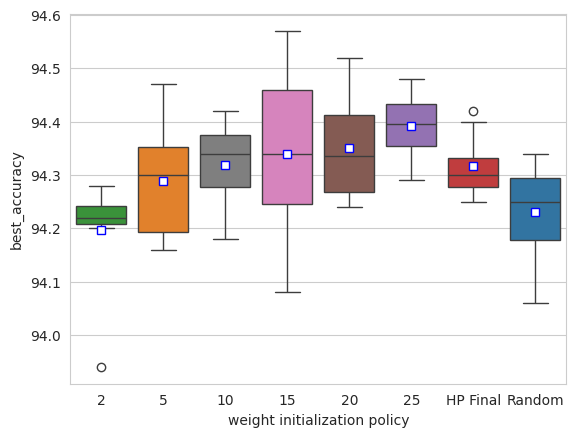

In [3]:
experiment_df = get_experiment_dataframe("./PaperCSVs/res18-c10/")

draw_plot_from_df(experiment_df=experiment_df, x='weight initialization policy', y='best_accuracy', plot_title="", file_name="fig2-res18-c10-accuracy.pdf")

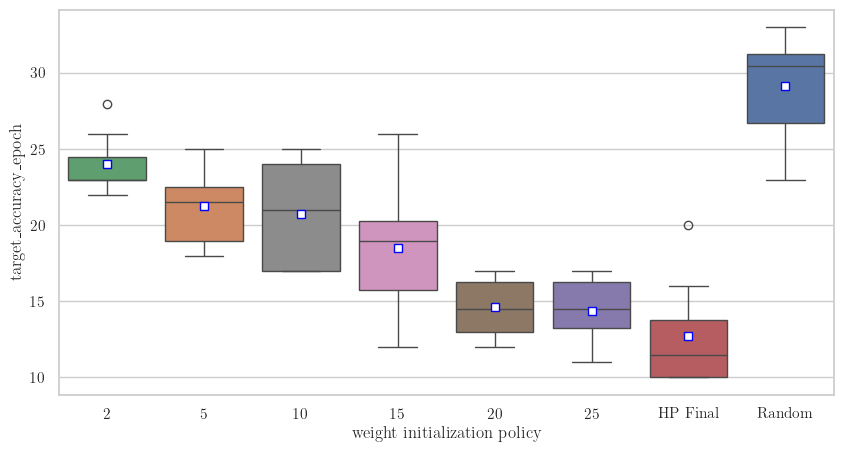

In [4]:
draw_plot_from_df(experiment_df=experiment_df, x='weight initialization policy', y='target_accuracy_epoch', plot_title="", file_name="fig3-res18-c10-tta.pdf")

In [5]:
# Table 1 contents

df_with_category_string_column = add_category_string_column(experiment_df)

means = df_with_category_string_column.groupby(['weight initialization policy'])[
    'best_accuracy'].mean().round(3)
stds = df_with_category_string_column.groupby(['weight initialization policy'])[
    'best_accuracy'].std().round(3)

# output_latex_table_content(df_with_category_string_column, "test.txt", ['hp-final', 'random', '2', '5', '10'])


export_latex_table(df_with_category_string_column, 'weight initialization policy')

Random & 94.231$\pm$0.098 & 29.125\\ 
5 & 94.289$\pm$0.107 & 21.25\\ 
2 & 94.198$\pm$0.108 & 24.0\\ 
HP Final & 94.316$\pm$0.061 & 12.75\\ 
25 & 94.391$\pm$0.061 & 14.375\\ 
20 & 94.351$\pm$0.103 & 14.625\\ 
15 & 94.339$\pm$0.166 & 18.5\\ 
10 & 94.319$\pm$0.085 & 20.75\\ 



# EXP2: ResNet-18 on CIFAR-100, Target Test Accuracy 75.00%
These correspond to Figure 4 and Table 2. The TTA Figure is not included in the paper.

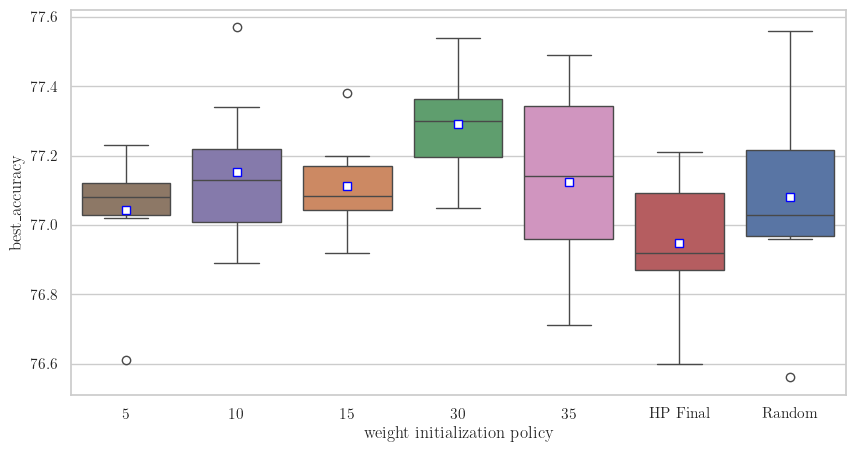

In [6]:
experiment_df = get_experiment_dataframe("./PaperCSVs/res18-c100/")

draw_plot_from_df(experiment_df=experiment_df, x='weight initialization policy', y='best_accuracy', plot_title="", file_name="fig4-res18-c100-accuracy.pdf")

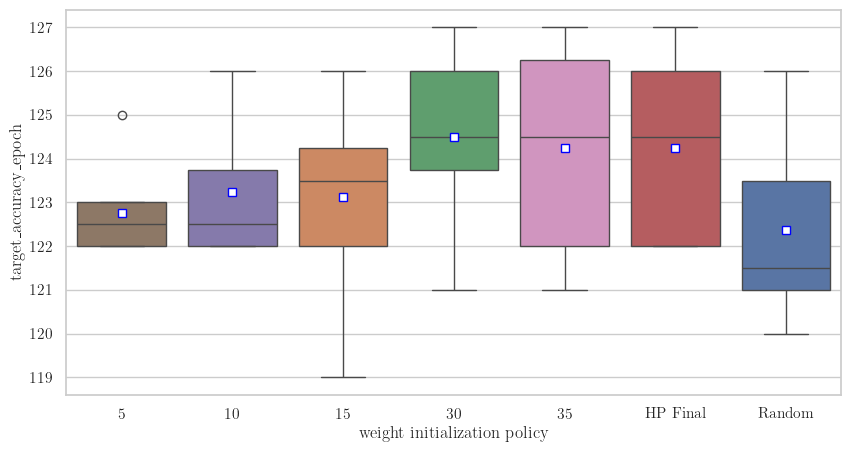

In [7]:
draw_plot_from_df(experiment_df=experiment_df, x='weight initialization policy', y='target_accuracy_epoch', plot_title="", file_name="fig4tta-res18-c100-tta.pdf")

In [8]:
# Table 2 contents

df_with_category_string_column = add_category_string_column(experiment_df)

means = df_with_category_string_column.groupby(['weight initialization policy'])[
    'best_accuracy'].mean().round(3)
stds = df_with_category_string_column.groupby(['weight initialization policy'])[
    'best_accuracy'].std().round(3)

# output_latex_table_content(df_with_category_string_column, "test.txt", ['hp-final', 'random', '2', '5', '10'])


export_latex_table(df_with_category_string_column, 'weight initialization policy')

Random & 77.08$\pm$0.299 & 122.375\\ 
15 & 77.112$\pm$0.138 & 123.125\\ 
30 & 77.292$\pm$0.181 & 124.5\\ 
HP Final & 76.947$\pm$0.193 & 124.25\\ 
10 & 77.152$\pm$0.219 & 123.25\\ 
5 & 77.044$\pm$0.191 & 122.75\\ 
35 & 77.124$\pm$0.287 & 124.25\\ 



# EXP3: ResNet-18 on Tiny ImageNet, Target Test Accuracy 40.00%
These correspond to Figure 5 and Table 3. The TTA Figure is not included in the paper.

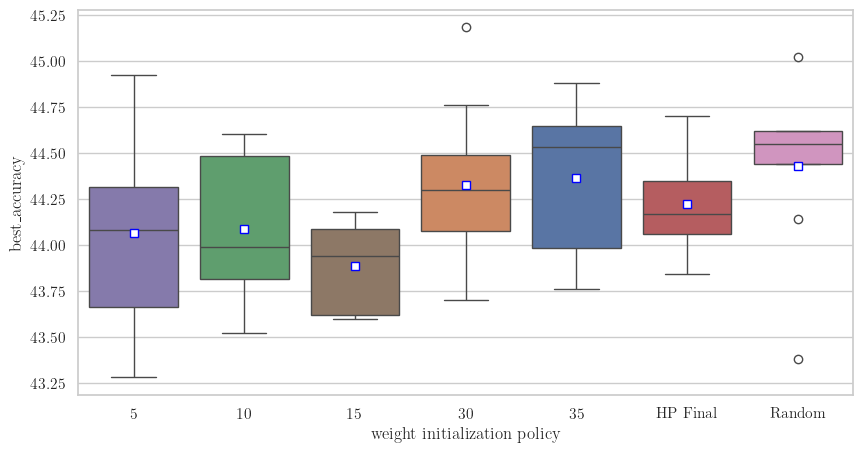

In [9]:
experiment_df = get_experiment_dataframe("./PaperCSVs/res18-tinyimagenet/")

draw_plot_from_df(experiment_df=experiment_df, x='weight initialization policy', y='best_accuracy', plot_title="", file_name="fig5-res18-tiny-imagenet-accuracy.pdf")

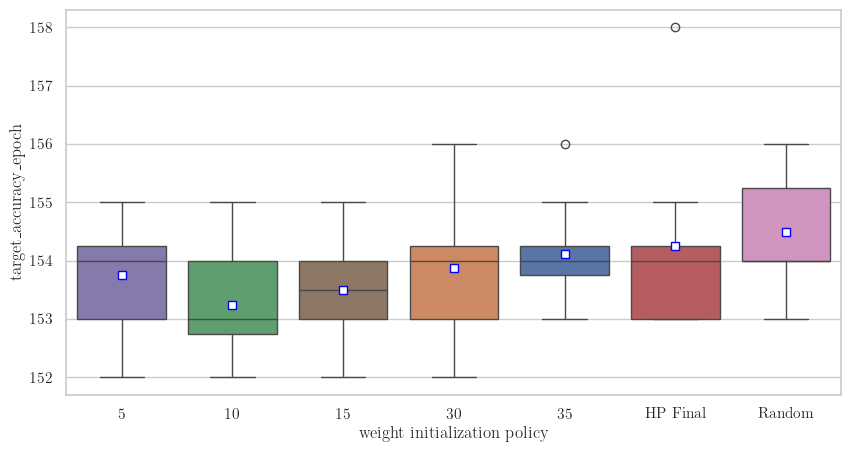

In [10]:
draw_plot_from_df(experiment_df=experiment_df, x='weight initialization policy', y='target_accuracy_epoch', plot_title="", file_name="fig5tta-res18-tiny-imagenet-tta.pdf")

In [11]:
# Table 3 contents

df_with_category_string_column = add_category_string_column(experiment_df)

means = df_with_category_string_column.groupby(['weight initialization policy'])[
    'best_accuracy'].mean().round(3)
stds = df_with_category_string_column.groupby(['weight initialization policy'])[
    'best_accuracy'].std().round(3)

# output_latex_table_content(df_with_category_string_column, "test.txt", ['hp-final', 'random', '2', '5', '10'])


export_latex_table(df_with_category_string_column, 'weight initialization policy')

35 & 44.362$\pm$0.415 & 154.125\\ 
30 & 44.328$\pm$0.479 & 153.875\\ 
10 & 44.085$\pm$0.403 & 153.25\\ 
HP Final & 44.223$\pm$0.275 & 154.25\\ 
5 & 44.062$\pm$0.536 & 153.75\\ 
15 & 43.885$\pm$0.245 & 153.5\\ 
Random & 44.428$\pm$0.485 & 154.5\\ 



# EXP4: ResNet-152 on CIFAR-100, Target Test Accuracy 75.00%
These correspond to Figure 6 and Table 4. The TTA Figure is not included in the paper.

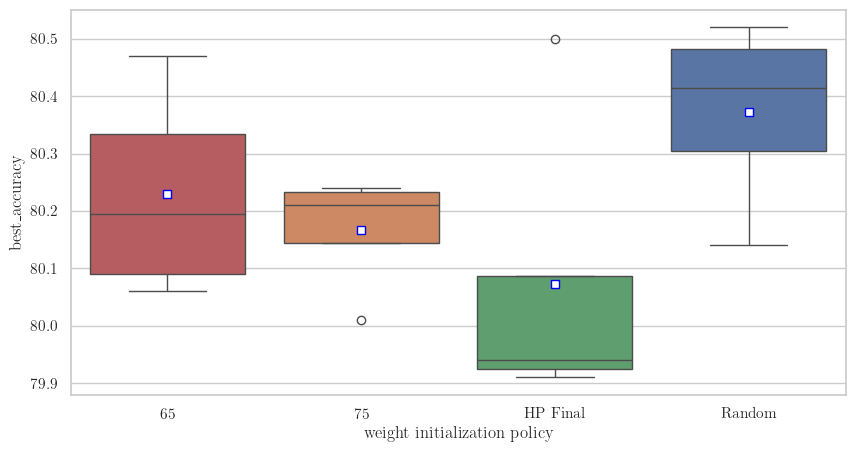

In [12]:
experiment_df = get_experiment_dataframe("./PaperCSVs/res152-c100/")

draw_plot_from_df(experiment_df=experiment_df, x='weight initialization policy', y='best_accuracy', plot_title="", file_name="fig6-res152-c100-accuracy.pdf")

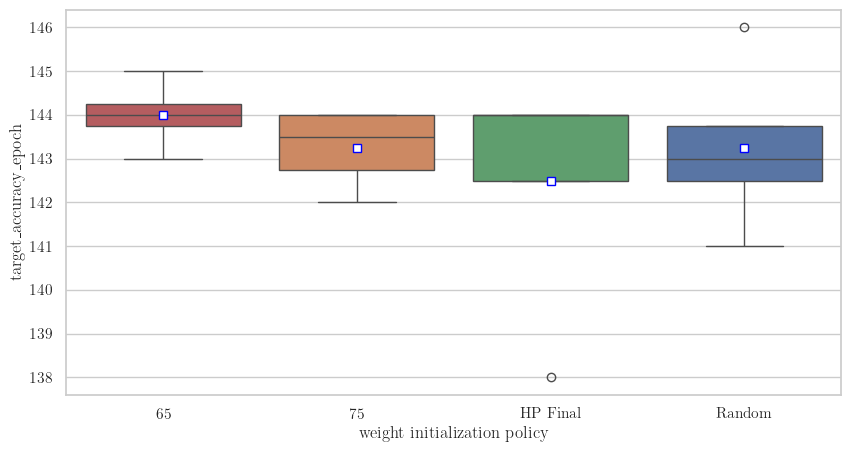

In [13]:
draw_plot_from_df(experiment_df=experiment_df, x='weight initialization policy', y='target_accuracy_epoch', plot_title="", file_name="fig6ttares152-c100-tta.pdf")

In [14]:
# Table 4 contents

df_with_category_string_column = add_category_string_column(experiment_df)

means = df_with_category_string_column.groupby(['weight initialization policy'])[
    'best_accuracy'].mean().round(3)
stds = df_with_category_string_column.groupby(['weight initialization policy'])[
    'best_accuracy'].std().round(3)

# output_latex_table_content(df_with_category_string_column, "test.txt", ['hp-final', 'random', '2', '5', '10'])


export_latex_table(df_with_category_string_column, 'weight initialization policy')

Random & 80.372$\pm$0.169 & 143.25\\ 
75 & 80.168$\pm$0.107 & 143.25\\ 
HP Final & 80.072$\pm$0.285 & 142.5\\ 
65 & 80.23$\pm$0.189 & 144.0\\ 



# EXP5: InceptionV3 on Food-101, Target Test Accuracy 70.00%
These correspond to Figure 7-8 and Table 5.

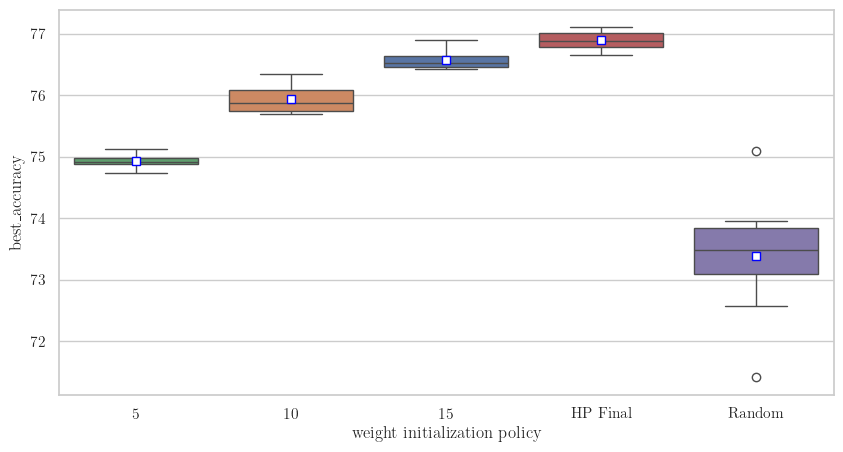

In [15]:
experiment_df = get_experiment_dataframe("./PaperCSVs/inceptionv3-food101/")

draw_plot_from_df(experiment_df=experiment_df, x='weight initialization policy', y='best_accuracy', plot_title="", file_name="fig7-inception-v3-food101-accuracy.pdf")

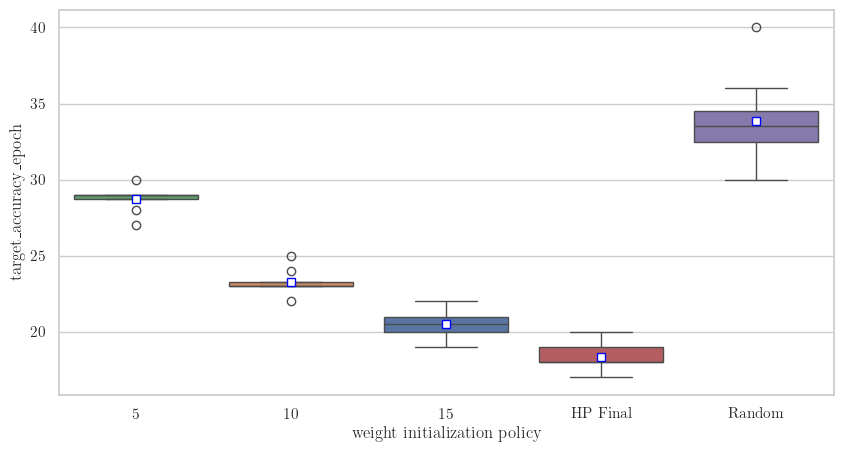

In [16]:
draw_plot_from_df(experiment_df=experiment_df, x='weight initialization policy', y='target_accuracy_epoch', plot_title="", file_name="fig8-inceptionv3-food101-tta.pdf")

In [17]:
# Table 5 contents

df_with_category_string_column = add_category_string_column(experiment_df)

means = df_with_category_string_column.groupby(['weight initialization policy'])[
    'best_accuracy'].mean().round(3)
stds = df_with_category_string_column.groupby(['weight initialization policy'])[
    'best_accuracy'].std().round(3)

# output_latex_table_content(df_with_category_string_column, "test.txt", ['hp-final', 'random', '2', '5', '10'])


export_latex_table(df_with_category_string_column, 'weight initialization policy')

15 & 76.572$\pm$0.155 & 20.5\\ 
10 & 75.935$\pm$0.23 & 23.25\\ 
5 & 74.93$\pm$0.115 & 28.75\\ 
HP Final & 76.894$\pm$0.158 & 18.375\\ 
Random & 73.385$\pm$1.073 & 33.875\\ 

